In [40]:
!pip install mne

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!ls /content/drive/MyDrive

 720p.mov
'APP Week 7'
 BreakersLive.gdoc
'CHEMISTRY  PROJECT (1).docx'
'CHEMISTRY  PROJECT.docx'
'Colab Notebooks'
'Compare Prehistory, Medieval and Present Engineering Development.docx'
 dataset_new.zip
 dataset.zip
'Document 3.pdf'
'Epson iPrint'
'Finish Ani Logo.mp4'
'Fortnite 2020.07.23 - 12.31.15.07.DVR.mp4'
'Fortnite clips'
'Fortnite Screenshot 2020.07.23 - 00.07.16.63.png'
 freedomtech.zip
'GC Mall'
'Google Earth'
'IMG_0959 (1).MOV'
 IMG_0959.MOV
 IMG_20220123_194626__01.jpg
'Internship ioc certificate.pdf'
'Liquid animation 2.mp4'
'Melt - Main TOP.mov'
'My Drive'
'My jett plays.mp4'
'O Re Piya.mp4'
 Piano
'POD Profit Calculator.gsheet'
 Resume-2.pdf.pdf
 Retry.mp4_1719926719312.mp4
 Screenshot_20200916-183647.jpg
'STUDENT PORTFOLIO_template (1).docx'
'STUDENT PORTFOLIO_template.docx'
 synthetic_eeg.fif
'ThePianist4 Wallpapaer 4K'
 UNIT-IV-COA_PPT.pptx
'Unit V.pptx'
'Untitled folder'
'Untitled folder (1)'
 wetransfer_dataset
 wetransfer_dataset_new
 wetransfer_dataset_new.zip
'

In [43]:
import mne

file_path = '/content/drive/MyDrive/synthetic_eeg.fif'
raw = mne.io.read_raw_fif(file_path, preload=True)

Opening raw data file /content/drive/MyDrive/synthetic_eeg.fif...
Isotrak not found
    Range : 0 ... 2559 =      0.000 ...     9.996 secs
Ready.
Reading 0 ... 2559  =      0.000 ...     9.996 secs...


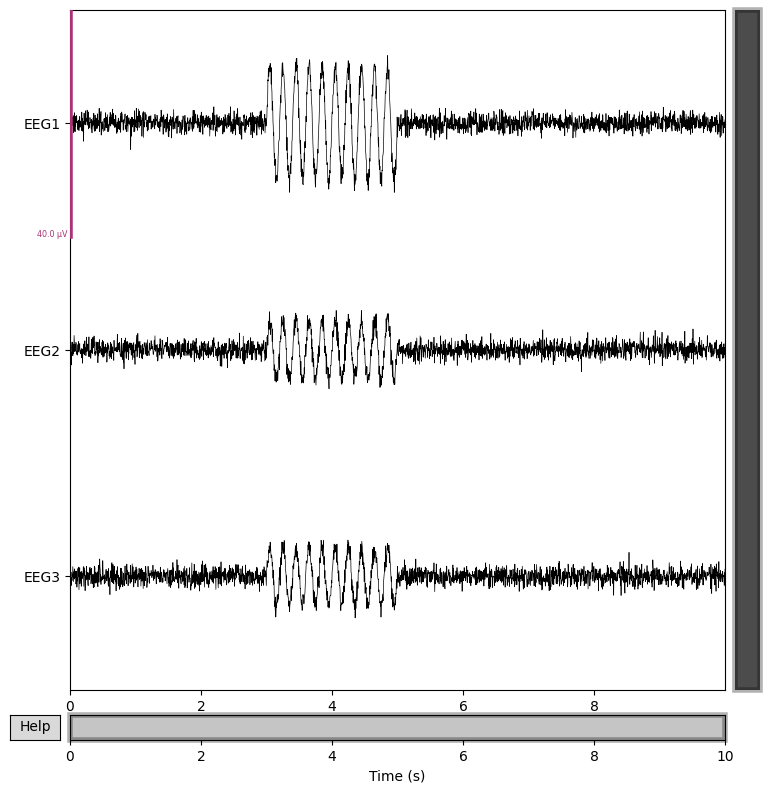

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



<Raw | synthetic_eeg.fif, 3 x 2560 (10.0 s), ~69 KiB, data loaded>

In [44]:
raw.plot()
raw.filter(0.5, 40)

In [45]:
new_channel_names = {'EEG1': 'Fp1', 'EEG2': 'Fp2', 'EEG3': 'Cz'}  # Adjust based on your data
raw.rename_channels(new_channel_names)

montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

<Raw | synthetic_eeg.fif, 3 x 2560 (10.0 s), ~72 KiB, data loaded>

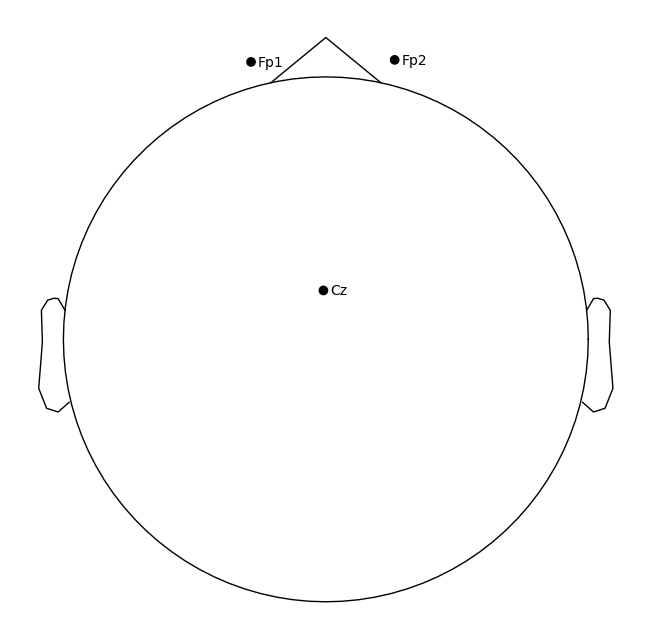

Fitting ICA to data using 3 channels (please be patient, this may take a while)
Selecting by number: 3 components
Fitting ICA took 0.0s.


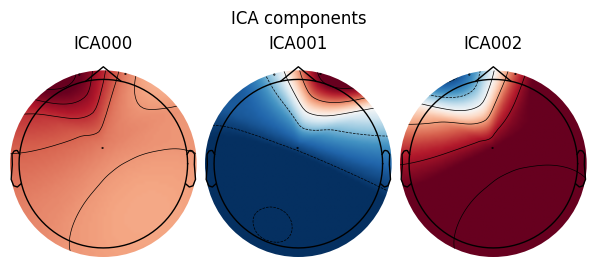

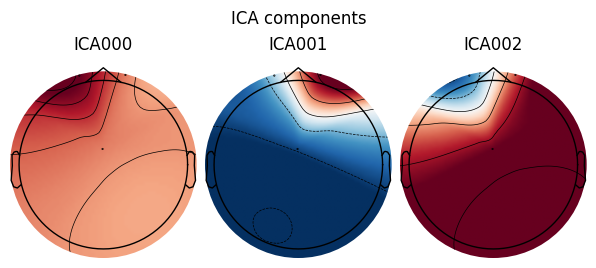

In [46]:
raw.plot_sensors(show_names=True)
ica = mne.preprocessing.ICA(n_components=3, random_state=97)
ica.fit(raw)
ica.plot_components()

In [47]:
epochs = mne.make_fixed_length_epochs(raw, duration=1, preload=True)

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 256 original time points ...
0 bad epochs dropped


In [48]:
import numpy as np
from sklearn.preprocessing import StandardScaler

data = epochs.get_data()
features = []

for epoch in data:
    mean_vals = np.mean(epoch, axis=1)
    var_vals = np.var(epoch, axis=1)
    features.append(np.concatenate([mean_vals, var_vals]))

features = np.array(features)
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [49]:
from sklearn.model_selection import train_test_split

labels = np.zeros(len(features))
labels[10:20] = 1

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_reshaped, y_train)

y_pred = model.predict(X_test_reshaped)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten

X_train_nn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_nn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_nn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_nn, y_train, epochs=10, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.3922 - loss: 0.6967
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6828 - loss: 0.6786 
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7445 - loss: 0.6585 
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7914 - loss: 0.6330 
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7602 - loss: 0.6239 
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7797 - loss: 0.6043
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7797 - loss: 0.5981  
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7719 - loss: 0.5869  
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7406 - loss: 0.6035  
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7328 - loss: 0.6033 


In [54]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_prob = model.predict(X_test_nn)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred_binary))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        19
         1.0       0.00      0.00      0.00         1

    accuracy                           0.95        20
   macro avg       0.47      0.50      0.49        20
weighted avg       0.90      0.95      0.93        20

ROC-AUC Score: 0.7894736842105263


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


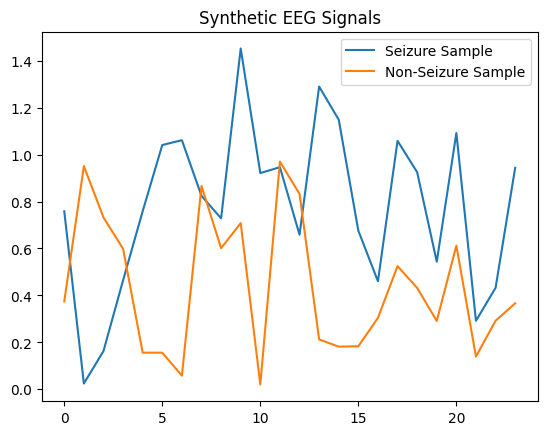

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten

# Generate synthetic data
np.random.seed(42)
n_samples = 100
time_steps = 6
n_features = 1
X = np.random.rand(n_samples, time_steps, n_features)

# Add seizure-like patterns
y = np.zeros(n_samples)
y[50:70] = 1
X[50:70] += 0.5 * np.sin(np.linspace(0, np.pi, time_steps)).reshape(1, -1, 1)

# Visualize samples
plt.plot(X[50].flatten(), label="Seizure Sample")
plt.plot(X[0].flatten(), label="Non-Seizure Sample")
plt.legend()
plt.title("Synthetic EEG Signals")
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(time_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 10, 32)              │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,593 (41.38 KB)

 Trainable params: 10,593 (41.38 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9018 - loss: 0.5374 - val_accuracy: 0.9062 - val_loss: 0.4110
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9368 - loss: 0.3435 - val_accuracy: 0.9062 - val_loss: 0.3875
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9370 - loss: 0.3070 - val_accuracy: 0.9062 - val_loss: 0.3951
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9395 - loss: 0.2867 - val_accuracy: 0.9062 - val_loss: 0.3885
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9297 - loss: 0.3098 - val_accuracy: 0.9062 - val_loss: 0.3660
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9239 - loss: 0.3095 - val_accuracy: 0.9062 - val_loss: 0.3502
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9212 - loss: 0.3063 - val_accuracy: 0.9062 - val_loss: 0.3381
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9426 - loss: 0.2316 - val_accuracy: 0.9062 - val_loss: 0.3268
E

In [67]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7937 - loss: 0.4992 
Test Loss: 0.48587894439697266, Test Accuracy: 0.800000011920929


In [68]:
sample_idx = 0
sample_signal = X_test[sample_idx].reshape(1, time_steps, n_features)
prediction = model.predict(sample_signal)
predicted_label = (prediction > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Prediction: Non-Seizure


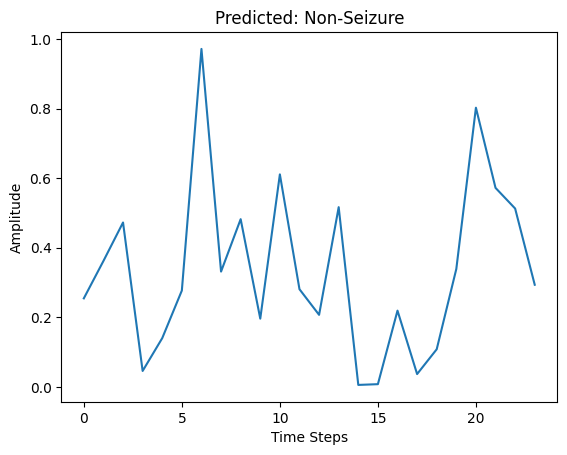

In [69]:
print(f"Prediction: {'Seizure' if predicted_label[0] == 1 else 'Non-Seizure'}")
plt.plot(X_test[sample_idx].flatten())
plt.title(f"Predicted: {'Seizure' if predicted_label[0] == 1 else 'Non-Seizure'}")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        32
         1.0       0.00      0.00      0.00         8

    accuracy                           0.80        40
   macro avg       0.40      0.50      0.44        40
weighted avg       0.64      0.80      0.71        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


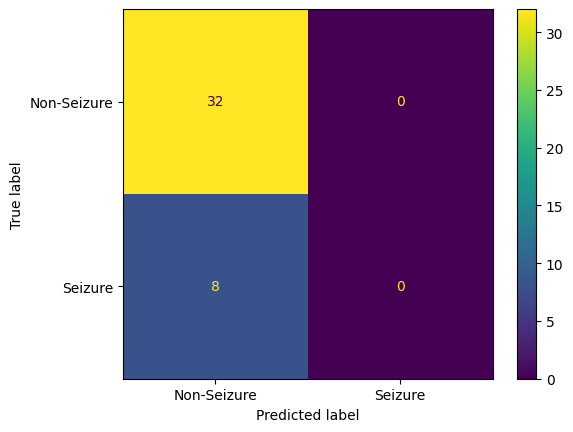

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Seizure', 'Seizure'])
disp.plot()
plt.show()